In [639]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile


Import data from .CSV files to panda dataframes

In [640]:
column_names = ['class', 'text']

training_set = pd.read_csv('data/train.csv', names = column_names)
development_set = pd.read_csv('data/dev.csv', names = column_names)
test_set = pd.read_csv('data/test.csv', names = column_names)

List of stop words 

In [641]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


Function that extracts unigrams from a document


In [642]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    # Tokenize string into list of unigrams
    tokens = re.findall(token_pattern, x_raw)

    tokens = [token.lower() for token in tokens]
    
    # Remove stop words
    if stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Extracted features
    x = []
    
    # Extract n-grams
    for n in range(ngram_range[0], ngram_range[1] + 1):
        for i in range(len(tokens) - n + 1):
            ngram = ' '.join(tokens[i:i + n])
            if vocab:  # If vocab is provided, filter by vocab
                if ngram in vocab:
                    x.append(ngram)
            else:
                x.append(ngram)
         
    return x

Create vocabulary of ngrams from list of documents

In [643]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    # Counters
    df = Counter()
    ngram_counts = Counter()
    
    # Extract ngrams, document frequencies, and raw frequencies
    for document in X_raw:
        ngrams = extract_ngrams(document, ngram_range, token_pattern, stop_words)
        
        # Update document frequencies
        df.update(set(ngrams))
        
        # Update ngram counts
        ngram_counts.update(ngrams)

    # Filter ngrams based on min_df
    if min_df > 0:
        # Create a list of ngrams to remove
        ngrams_to_remove = [ngram for ngram, freq in df.items() if freq < min_df]
    
        # Remove ngrams from df and ngram_counts
        for ngram in ngrams_to_remove:
            df.pop(ngram)
            ngram_counts.pop(ngram)

    # Keep top-N frequent ngrams
    if keep_topN > 0:
        ngram_counts = dict(ngram_counts.most_common(keep_topN))
        df = {ngram: freq for ngram, freq in df.items() if ngram in ngram_counts}

    # Extract vocabulary
    vocab = set(df.keys())
    
    return vocab, df, ngram_counts

In [644]:
vocab, df, ngram_counts = get_vocab(training_set['text'], ngram_range=(1,1), stop_words=stop_words)

Vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [645]:
id2word = {i:word for i, word in enumerate(vocab)}
word2id = {word:i for i, word in enumerate(vocab)}

print(id2word)
print(word2id)

{0: 'gains', 1: 'continent', 2: 'ballpark', 3: 'days', 4: 'assumption', 5: 'landed', 6: 'happened', 7: 'pieter', 8: 'katerina', 9: 'proof', 10: 'nec', 11: 'apmf', 12: 'agencies', 13: 'heading', 14: 'draw', 15: 'least', 16: 'jay', 17: 'demanding', 18: 'receiver', 19: 'visible', 20: 'crushed', 21: 'savor', 22: 'abdul', 23: 'slide', 24: 'domestic', 25: 'pair', 26: 'sack', 27: 'breaststroke', 28: 'silver', 29: 'agreement', 30: 'attacks', 31: 'officially', 32: 'parry', 33: 'guarding', 34: 'color', 35: 'wmt', 36: 'routes', 37: 'stars', 38: 'landings', 39: 'chairman', 40: 'determine', 41: 'clearing', 42: 'prescription', 43: 'ms', 44: 'todd', 45: 'while', 46: 'troops', 47: 'accusations', 48: 'took', 49: 'featureless', 50: 'travel', 51: 'under', 52: 'tagged', 53: 'concacaf', 54: 'evidenced', 55: 'praised', 56: 'player', 57: 'douse', 58: 'kerri', 59: 'healthsouth', 60: 'quietly', 61: 'nasty', 62: 'submit', 63: 'prv', 64: 'jr', 65: 'sap', 66: 'bunkers', 67: 'conservative', 68: 'timing', 69: 'bild

Represent documents in train, dev and test sets as lists of words in the vocabulary

In [646]:
def document_to_words(document):
    words = document.split()
    words_in_vocab= []
    for word in words:
        if word in vocab:
            words_in_vocab.append(word)

    return words_in_vocab

training_documents = [document_to_words(document) for document in training_set['text']]
development_documents = [document_to_words(document) for document in development_set['text']]
test_documents = [document_to_words(document) for document in test_set['text']]

Convert them into lists of indices in the vocabulary

In [647]:
def document_to_indices(document):
    word_indices = []
    for word in document:
        if word in vocab:
            word_indices.append(word2id[word])

    return word_indices

X_tr = [document_to_indices(document) for document in training_documents]
X_dev = [document_to_indices(document) for document in development_documents]
X_te = [document_to_indices(document) for document in test_documents]

Put labels for train, dev and test sets into arrays (subtrack 1 to make labels 0-based)

In [648]:
Y_tr = list(training_set['class'])
Y_tr = list(y - 1 for y in Y_tr)
Y_dev = list(development_set['class'])
Y_dev = list(y - 1 for y in Y_dev)
Y_te = list(test_set['class'])
Y_te = list(y - 1 for y in Y_te)

Remove empty documends

In [649]:
empty_doc_indices = [i for i, x in enumerate(X_tr) if len(x) == 0]
for i in reversed(empty_doc_indices):
    del X_tr[i]
    del Y_tr[i]

empty_doc_indices = [i for i, x in enumerate(X_dev) if len(x) == 0]
for i in reversed(empty_doc_indices):
    del X_dev[i]
    del Y_dev[i]

empty_doc_indices = [i for i, x in enumerate(X_te) if len(x) == 0]
for i in reversed(empty_doc_indices):
    del X_te[i]
    del Y_te[i]

Initialise the weights of the embedding matrix and the hidden layer matrices.

In [650]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):

    # Weight matrices
    W = {}
    
    # Initialize embedding matrix
    W[0] = np.random.uniform(-init_val, init_val, (vocab_size, embedding_dim)).astype(np.float64)
    
    # Initialize hidden layers
    if len(hidden_dim) > 0:
        for i in range(len(hidden_dim)):
            if i == 0:
                W[i + 1] = np.random.uniform(-init_val, init_val, (embedding_dim, hidden_dim[i])).astype(np.float64)
            else:
                W[i + 1] = np.random.uniform(-init_val, init_val, (hidden_dim[i - 1], hidden_dim[i])).astype(np.float64)
    
    # Initialize output layer
    if len(hidden_dim) > 0:
        W[len(hidden_dim) + 1] = np.random.uniform(-init_val, init_val, (hidden_dim[-1], num_classes)).astype(np.float64)
    else:
        W[1] = np.random.uniform(-init_val, init_val, (embedding_dim, num_classes)).astype(np.float64)

    return W
    

In [651]:
W = network_weights(vocab_size=100,embedding_dim=4,hidden_dim=[200, 100], num_classes=2)

for i in range(len(W)):
    print(f"W[{i}].shape = {W[i].shape}")

W[0].shape = (100, 4)
W[1].shape = (4, 200)
W[2].shape = (200, 100)
W[3].shape = (100, 2)


Softmax function adapted from the pytorch implementation

In [652]:
def softmax(z):
    
    max_val = np.max(z)
    z_exp = np.exp(z - max_val)
    sig = z_exp / np.sum(z_exp)
    return sig

Categorical cross entropy loss and its gradient


In [653]:
def categorical_loss(y, y_preds):

    epsilon = 1e-10

    y_onehot = np.zeros_like(y_preds)
    y_onehot[y] = 1
    
    l = -np.sum(y_onehot * np.log(y_preds + epsilon))/len(y_preds)

    return l

def grad_categorical_loss(y, y_preds):

    y_onehot = np.zeros_like(y_preds)
    y_onehot[y] = 1
    
    grad = (y_preds - y_onehot) / len(y_preds)
    
    return grad

Relu activation function and its derivative

In [654]:
def relu(z):

    z_copy = np.copy(z)
    
    a = np.maximum(z_copy, 0) 

    return a
    
def relu_derivative(z):

    z_copy = np.copy(z)
    dz = np.where(z_copy <= 0, 0, 1)
    
    return dz

Dropout mask

In [655]:
def dropout_mask(size, dropout_rate):

    dropout_vec = []

    for i in range(size):
        if np.random.rand() < dropout_rate:
            dropout_vec.append(0)
        else:
            dropout_vec.append(1)
    
    return dropout_vec

Forward pass

In [656]:
def forward_pass(x, W, dropout_rate=0.2):
  
    out_vals = {}

    h_vecs = []
    a_vecs = []
    dropout_vecs = []

    num_layers = len(W) - 1

    a = x
    a_vecs.append(a)

    sum_h = 0
    for i in x:
        sum_h += W[0][i]

    # Pass input through embedding layer
    h = sum_h / len(x)
    a = relu(h)

    dropout = dropout_mask(a.shape[0], dropout_rate) 
    a *= dropout

    # Store values for the first layer
    h_vecs.append(h)
    a_vecs.append(a)
    dropout_vecs.append(dropout)

    # Pass through the rest of the layers
    for i in range(1, num_layers):
        h = np.dot(a, W[i])
        a = relu(h)

        dropout = dropout_mask(a.shape[0], dropout_rate) 
        a *= dropout
        
        # Store values for this layer
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(dropout)
        
    # Compute output layer
    h = np.dot(a, W[num_layers])
    y = softmax(h)

    h_vecs.append(h)
    a_vecs.append(y)

    # Store output layer values
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout'] = dropout_vecs
    out_vals['y'] = y

    return out_vals

Backward pass  

In [657]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):

    h_vecs = out_vals['h']
    a_vecs = out_vals['a']
    y_pred = out_vals['y']
    
    num_layers = len(W) - 1
    num_samples = len(x)

    # Compute gradient on the output layer
    g = grad_categorical_loss(y, y_pred)
    
    # Compute gradients for layers and update weights
    for i in range(num_layers, -1, -1):
        
        if i == 0:
            if freeze_emb:
                continue
            else:
                g *= np.array(relu_derivative(h_vecs[i]))
                dl_dW = g / num_samples
                for j in x:
                    W[i][j] -= lr * dl_dW

        else:

            g *= np.array(relu_derivative(h_vecs[i]))

            dl_dW = g * a_vecs[i].reshape(-1, 1)
       
            g = np.dot(g, W[i].T) 

            W[i] -= lr * dl_dW 

    return W

Stohastic gradient descent

In [658]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []

    prev_validation_loss = 0

    for epoch in range(epochs):
        # Randomize training data
        indices = np.arange(len(X_tr))
        np.random.shuffle(indices)
        training_loss = 0
        for idx in indices:
            x = X_tr[idx]
            y = Y_tr[idx]
            out_vals = forward_pass(x, W, dropout_rate = dropout)
            W = backward_pass(x, y, W, out_vals, lr, freeze_emb)
            training_loss += categorical_loss(y, out_vals['y'])
        training_loss_history.append(training_loss)

        # Validation loop and loss
        if X_dev and Y_dev:
            # Randomize training data
            indices_dev = np.arange(len(X_dev))
            np.random.shuffle(indices_dev)
            validation_loss = 0
            for idx in indices_dev:
                x_dev = X_dev[idx]
                y_dev = Y_dev[idx]
                out_vals_dev = forward_pass(x_dev, W, dropout_rate=dropout)
                validation_loss += categorical_loss(y_dev, out_vals_dev['y'])
            validation_loss_history.append(validation_loss)

        if print_progress:
            print(f"Epoch {epoch + 1}: Training Loss = {training_loss}", end="")
            if len(X_dev) > 0 and len(Y_dev) > 0:
                print(f", Validation Loss = {validation_loss}")
            else:
                print("")
            
        # Check for early stopping
        if tolerance != "None":
            if epoch > 0 and prev_validation_loss - validation_loss < tolerance:
                print(f"Stopped training early at epoch {epoch + 1} due to convergence.")
                break
        prev_validation_loss = validation_loss


    return W, training_loss_history, validation_loss_history

Training the neural network

In [659]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3, init_val=0.1)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.5, 
                            dropout=0.5,
                            freeze_emb=False,
                            tolerance=1e-5,
                            epochs=100)

Epoch 1: Training Loss = 869.3888166369886, Validation Loss = 53.136124231159556
Epoch 2: Training Loss = 735.119484327327, Validation Loss = 39.488844298368406
Epoch 3: Training Loss = 444.47369074322677, Validation Loss = 26.525975308369
Epoch 4: Training Loss = 260.4101444403114, Validation Loss = 24.251313203284898
Epoch 5: Training Loss = 160.89649771092098, Validation Loss = 24.459855584083567
Stopped training early at epoch 5 due to convergence.


Ploting the learning process

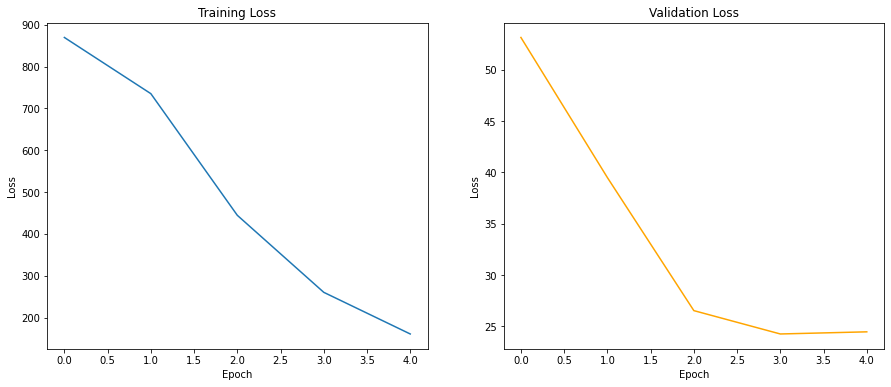

In [660]:
# plot the training and validation loss
%matplotlib inline  

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(loss_tr, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Training Loss')

axs[1].plot(dev_loss, label='Validation Loss', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].title.set_text('Validation Loss')

plt.show()

Compute accuracy, precision, recall and F1-Score

In [661]:
preds_te_initial_model = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te_initial_model))
print('Precision:', precision_score(Y_te,preds_te_initial_model,average='macro'))
print('Recall:', recall_score(Y_te,preds_te_initial_model,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te_initial_model,average='macro'))


Accuracy: 0.8155555555555556
Precision: 0.8166006268737219
Recall: 0.8155555555555555
F1-Score: 0.814547326850568


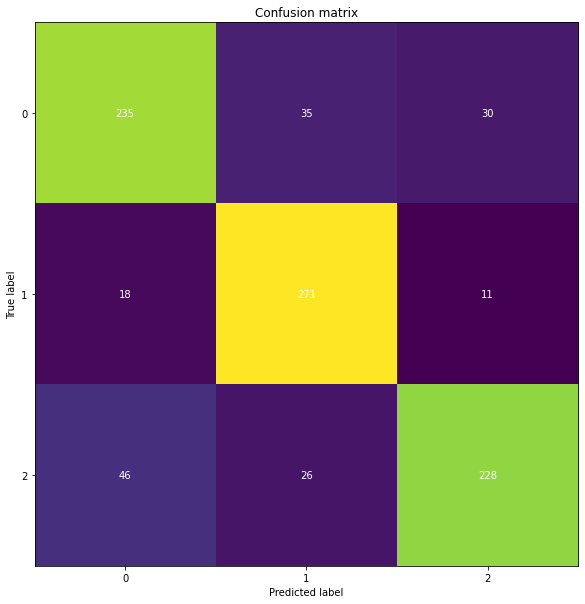

In [662]:
# Function to calculate confusion matrix
def calculate_confusion_matrix(true_labels, predictions):
    confusion_matrix = np.zeros((np.max(true_labels)+1, np.max(true_labels)+1), dtype=int)
    for i in range(len(true_labels)):
        confusion_matrix[true_labels[i], predictions[i]] += 1
    return confusion_matrix

# Calculate confusion matrices for all three models
confusion_matrix_model1 = calculate_confusion_matrix(Y_te, preds_te_initial_model)

# Plot confusion matrices

fig = plt.figure(figsize=(10, 10))

# Plot for initial model
plt.imshow(confusion_matrix_model1, cmap='viridis', interpolation='nearest')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(np.max(Y_te)+1))
plt.yticks(np.arange(np.max(Y_te)+1))
for i in range(np.max(Y_te)+1):
    for j in range(np.max(Y_te)+1):
        plt.text(j, i, confusion_matrix_model1[i, j], ha='center', va='center', color='white')


Choosing hyperparameters

In [663]:
# random.seed(42)
# np.random.seed(42)

# best_f1 = 0
# best_params = (0, 0, 0)

# training_losses = []
# validation_losses = []
# param_lists = []

# for emb in [100, 300]:
#     for lr in [0.5, 0.05]:
#         for dropout in [0.2, 0.5]:
#             # Store the parameter combination
#             param_lists.append((emb, lr, dropout))

#             W = network_weights(vocab_size=len(vocab), embedding_dim=emb,
#                                 hidden_dim=[], num_classes=3, init_val=0.1)

#             W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
#                                         W,
#                                         X_dev=X_dev,
#                                         Y_dev=Y_dev,
#                                         lr=lr,
#                                         dropout=dropout,
#                                         freeze_emb=False,
#                                         tolerance=1e-5,
#                                         epochs=100,
#                                         print_progress=False)

#             # Append training and validation losses to lists
#             training_losses.append(loss_tr)
#             validation_losses.append(dev_loss)

#             preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
#                         for x, y in zip(X_te, Y_te)]

#             f1 = f1_score(Y_te, preds_te, average='macro')
#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_params = (emb, lr, dropout)

#             print(f'Embedding size: {emb}, Learning rate: {lr}, Dropout: {dropout}')
#             print('Accuracy:', accuracy_score(Y_te, preds_te))
#             print('Precision:', precision_score(Y_te, preds_te, average='macro'))
#             print('Recall:', recall_score(Y_te, preds_te, average='macro'))
#             print('F1-Score:', f1)
#             print("-----------------------------------------------------------------------------------------")

# print(f"Best F1-Score: {best_f1}")
# print(f"Best parameters: {best_params}")

# # Plot training losses

# fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# for i, loss_tr in enumerate(training_losses):
#     axs[0].plot(loss_tr, label=f'Emb={param_lists[i][0]}, LR={param_lists[i][1]}, Dropout={param_lists[i][2]}')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Loss')
# axs[0].title.set_text('Training Losses')
# axs[0].legend()

# # Plot validation losses
# for i, dev_loss in enumerate(validation_losses):
#     axs[1].plot(dev_loss, label=f'Emb={param_lists[i][0]}, LR={param_lists[i][1]}, Dropout={param_lists[i][2]}')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Loss')
# axs[1].title.set_text('Validation Losses')
# axs[1].legend()

# plt.show()

# Using pre-trained, GloVe embeddings

This function reads GloVe embeddings from a file and returns a dictionary that maps words to their corresponding word vectors.

In [664]:
# def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
#     w_emb = np.zeros((len(word2id), emb_size))

#     error_count = 0
    
#     with zipfile.ZipFile(f_zip) as z:
#         with z.open(f_txt) as f:
#             for line in f:
#                 line = line.decode('utf-8')
#                 word = line.split()[0]

#                 if word in vocab:
#                     try:
#                         emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
#                         w_emb[word2id[word]] += emb
#                     except:
#                         error_count += 1

#     print(f"Number of errors: {error_count}")
                    
#     return w_emb

# w_glove = get_glove_embeddings("glove.840B.300d.zip", "glove.840B.300d.txt", word2id, emb_size=300)